<a href="https://colab.research.google.com/github/ChanceDurr/AB-Demo/blob/master/notebooks/Chance_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
# !pip install kaggle
# !mkdir .kaggle

# import json
# token = ''
# with open('/content/.kaggle/kaggle.json', 'w') as file:
#     json.dump(token, file)
    
# !cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/content}

# !chmod 600 /root/.kaggle/kaggle.json


# !kaggle competitions download -c champs-scalar-coupling

In [271]:
!pip install category_encoders eli5

from category_encoders import OrdinalEncoder, OneHotEncoder
import eli5
from eli5.sklearn import PermutationImportance

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder as OHE

from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm

In [0]:
# !unzip /content/{/content}/competitions/champs-scalar-coupling/dipole_moments.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/structures.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/scalar_coupling_contributions.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/magnetic_shielding_tensors.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/mulliken_charges.csv.zip
# !unzip /content/{/content}/competitions/champs-scalar-coupling/potential_energy.csv.zip

In [0]:
trainval = pd.read_csv('/content/{/content}/competitions/champs-scalar-coupling/train.csv.zip')
test = pd.read_csv('/content/{/content}/competitions/champs-scalar-coupling/test.csv.zip')
structures = pd.read_csv('/content/structures.csv')
dipole = pd.read_csv('/content/dipole_moments.csv')
contrib = pd.read_csv('/content/scalar_coupling_contributions.csv')
magnetic = pd.read_csv('/content/magnetic_shielding_tensors.csv')
mulliken = pd.read_csv('/content/mulliken_charges.csv')
potential_energy = pd.read_csv('/content/potential_energy.csv')
test_mulliken = pd.read_csv('/content/mulliken_charges_test_set.csv')

## Merge structures function

In [0]:
def merge_train_structures(train, structures):
  
  """This function is used to merge the structures dataset to the 
     original train dataset
     
     Parameters:
     ===========
	   train: train dataframe
	   structures: structures dataframe.
     
     Output:
	   ===========
	   dataframe: merged dataframe
     """
  
  structures = structures.rename({'atom_index': 'atom_index_0',
                                  'x':'x_0', 'y':'y_0', 'z':'z_0',
                                  'atom':'atom_0'}, axis=1)
  
  merged = pd.merge(train, structures, on=['molecule_name', 'atom_index_0'])
  
  structures = structures.rename({'atom_index_0': 'atom_index_1',
                                  'x_0':'x_1', 'y_0':'y_1', 'z_0':'z_1',
                                  'atom_0':'atom_1'}, axis=1)
  
  merged_1 = pd.merge(merged, structures, on=['molecule_name', 'atom_index_1'])
  
  structures = structures.rename({'atom_index_1': 'atom_index',
                                  'x_1':'x', 'y_1':'y', 'z_1':'z',
                                  'atom_1':'atom'}, axis=1)
  
  assert train.shape[0] == merged.shape[0]
  
  return merged_1

In [0]:
merged = merge_train_structures(trainval, structures)

In [276]:
merged.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001
2,7,dsgdb9nsd_000001,3,0,1JHC,84.8093,H,-0.540815,1.447527,-0.876644,C,-0.012698,1.085804,0.008001
3,9,dsgdb9nsd_000001,4,0,1JHC,84.8095,H,-0.523814,1.437933,0.906397,C,-0.012698,1.085804,0.008001
4,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277


In [0]:
mulliken = mulliken.rename({'atom_index': 'atom_index_0',
                          'mulliken_charge': 'mulliken_charge_0'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_0'])

mulliken = mulliken.rename({'atom_index_0': 'atom_index_1',
                          'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
merged = merged.merge(mulliken, on=['molecule_name', 'atom_index_1'])

## Feature Engineering

In [0]:
external_data_0 = pd.DataFrame(data={
    'atom_0': ['C', 'H', 'N', 'O', 'F'],
    'atom_0_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_0': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_0': [4, 1, 5, 6, 7]
})
external_data_1 = pd.DataFrame(data={
    'atom_1': ['C', 'H', 'N', 'O', 'F'],
    'atom_1_en': [2.55, 2.20, 3.04, 3.44, 3.98],
    'atomic_mass_1': [12.0107, 1.00784, 14.0067, 15.999, 18.9984],
    'valence_electrons_1': [4, 1, 5, 6, 7]
})

In [0]:
def feature_eng(df):
  df['bond'] = df['type'].str[2:]
  df['j_type'] = df['type'].str[:2]
  df['distance'] = ((df['x_1'].values - df['x_0'].values)**2 + 
                  (df['y_1'].values - df['y_0'].values)**2 + 
                  (df['z_1'].values - df['z_0'].values)**2)** 0.5
  df['mu_0'] = np.sqrt(df['x_0'].values**2 + df['y_0'].values**2 + df['z_0'].values**2)
  df['mu_1'] = np.sqrt(df['x_1'].values**2 + df['y_1'].values**2 + df['z_1'].values**2)
  df = df.merge(external_data_0, on='atom_0', how='left')
  df = df.merge(external_data_1, on='atom_1', how='left')
  df['delta_en'] = (df['atom_0_en'] - df['atom_1_en']).abs()
#   df = df.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)
  return df

In [0]:
merged = feature_eng(merged)

## Scoring Function

In [0]:
groups = merged['type']

def group_lmae(y_true, y_pred, groups, floor=1e-9):
  maes = (y_true - y_pred).abs().groupby(groups).mean()
  return np.log(maes.map(lambda x: max(x, floor))).mean()

## Splitting

In [0]:
trainval_1JHC = merged[merged['type'] == '1JHC']
trainval_1JHN = merged[merged['type'] == '1JHN']
trainval_2JHH = merged[merged['type'] == '2JHH']
trainval_2JHN = merged[merged['type'] == '2JHN']
trainval_2JHC = merged[merged['type'] == '2JHC']
trainval_3JHH = merged[merged['type'] == '3JHH']
trainval_3JHC = merged[merged['type'] == '3JHC']
trainval_3JHN = merged[merged['type'] == '3JHN']

In [0]:
train_1JHC, val_1JHC = train_test_split(trainval_1JHC, shuffle=False, random_state=47)

train_1JHC_molecules = train_1JHC['molecule_name'].unique()
val_1JHC_molecules = np.delete(val_1JHC['molecule_name'].unique(), 0)

train_1JHC = train_1JHC[train_1JHC['molecule_name'].isin(train_1JHC_molecules)]
val_1JHC = val_1JHC[val_1JHC['molecule_name'].isin(val_1JHC_molecules)]

In [0]:
train_1JHN, val_1JHN = train_test_split(trainval_1JHN, shuffle=False, random_state=47)

train_1JHN_molecules = train_1JHN['molecule_name'].unique()
val_1JHN_molecules = np.delete(val_1JHN['molecule_name'].unique(), 0)

train_1JHN = train_1JHN[train_1JHN['molecule_name'].isin(train_1JHN_molecules)]
val_1JHN = val_1JHN[val_1JHN['molecule_name'].isin(val_1JHN_molecules)]

In [0]:
train_2JHH, val_2JHH = train_test_split(trainval_2JHH, shuffle=False, random_state=47)

train_2JHH_molecules = train_2JHH['molecule_name'].unique()
val_2JHH_molecules = np.delete(val_2JHH['molecule_name'].unique(), 0)

train_2JHH = train_2JHH[train_2JHH['molecule_name'].isin(train_2JHH_molecules)]
val_2JHH = val_2JHH[val_2JHH['molecule_name'].isin(val_2JHH_molecules)]

In [0]:
train_2JHN, val_2JHN = train_test_split(trainval_2JHN, shuffle=False, random_state=47)

train_2JHN_molecules = train_2JHN['molecule_name'].unique()
val_2JHN_molecules = np.delete(val_2JHN['molecule_name'].unique(), 0)

train_2JHN = train_2JHN[train_2JHN['molecule_name'].isin(train_2JHN_molecules)]
val_2JHN = val_2JHN[val_2JHN['molecule_name'].isin(val_2JHN_molecules)]

In [0]:
train_2JHC, val_2JHC = train_test_split(trainval_2JHC, shuffle=False, random_state=47)

train_2JHC_molecules = train_2JHC['molecule_name'].unique()
val_2JHC_molecules = np.delete(val_2JHC['molecule_name'].unique(), 0)

train_2JHC = train_2JHC[train_2JHC['molecule_name'].isin(train_2JHC_molecules)]
val_2JHC = val_2JHC[val_2JHC['molecule_name'].isin(val_2JHC_molecules)]

In [0]:
train_3JHH, val_3JHH = train_test_split(trainval_3JHH, shuffle=False, random_state=47)

train_3JHH_molecules = train_3JHH['molecule_name'].unique()
val_3JHH_molecules = np.delete(val_3JHH['molecule_name'].unique(), 0)

train_3JHH = train_3JHH[train_3JHH['molecule_name'].isin(train_3JHH_molecules)]
val_3JHH = val_3JHH[val_3JHH['molecule_name'].isin(val_3JHH_molecules)]

In [0]:
train_3JHC, val_3JHC = train_test_split(trainval_3JHC, shuffle=False, random_state=47)

train_3JHC_molecules = train_3JHC['molecule_name'].unique()
val_3JHC_molecules = np.delete(val_3JHC['molecule_name'].unique(), 0)

train_3JHC = train_3JHC[train_3JHC['molecule_name'].isin(train_3JHC_molecules)]
val_3JHC = val_3JHC[val_3JHC['molecule_name'].isin(val_3JHC_molecules)]

In [0]:
train_3JHN, val_3JHN = train_test_split(trainval_3JHN, shuffle=False, random_state=47)

train_3JHN_molecules = train_3JHN['molecule_name'].unique()
val_3JHN_molecules = np.delete(val_3JHN['molecule_name'].unique(), 0)

train_3JHN = train_3JHN[train_3JHN['molecule_name'].isin(train_3JHN_molecules)]
val_3JHN = val_3JHN[val_3JHN['molecule_name'].isin(val_3JHN_molecules)]

## X_train, y_train, X_val, y_val

In [0]:
features = ['atom_index_0', 'atom_index_1', 'distance', 'atom_0_en',
            'atom_1_en', 'mu_0', 'mu_1', 'mulliken_charge_0',
            'mulliken_charge_1', 'x_0', 'x_1', 'y_0', 'y_1', 'z_0', 'z_1']
target = 'scalar_coupling_constant'

X_train_1JHC = train_1JHC[features]
X_train_1JHN = train_1JHN[features]
X_train_2JHH = train_2JHH[features]
X_train_2JHN = train_2JHN[features]
X_train_2JHC = train_2JHC[features]
X_train_3JHH = train_3JHH[features]
X_train_3JHC = train_3JHC[features]
X_train_3JHN = train_3JHN[features]

y_train_1JHC = train_1JHC[target]
y_train_1JHN = train_1JHN[target]
y_train_2JHH = train_2JHH[target]
y_train_2JHN = train_2JHN[target]
y_train_2JHC = train_2JHC[target]
y_train_3JHH = train_3JHH[target]
y_train_3JHC = train_3JHC[target]
y_train_3JHN = train_3JHN[target]


X_val_1JHC = val_1JHC[features]
X_val_1JHN = val_1JHN[features]
X_val_2JHH = val_2JHH[features]
X_val_2JHN = val_2JHN[features]
X_val_2JHC = val_2JHC[features]
X_val_3JHH = val_3JHH[features]
X_val_3JHC = val_3JHC[features]
X_val_3JHN = val_3JHN[features]

y_val_1JHC = val_1JHC[target]
y_val_1JHN = val_1JHN[target]
y_val_2JHH = val_2JHH[target]
y_val_2JHN = val_2JHN[target]
y_val_2JHC = val_2JHC[target]
y_val_3JHH = val_3JHH[target]
y_val_3JHC = val_3JHC[target]
y_val_3JHN = val_3JHN[target]

## Encoding

In [0]:
def encode(df):
  df = OrdinalEncoder.fit_transform(OrdinalEncoder(df), df)
  return df

In [0]:
X_train_1JHC_encoded = encode(X_train_1JHC)
X_train_1JHN_encoded = encode(X_train_1JHN)
X_train_2JHH_encoded = encode(X_train_2JHH)
X_train_2JHC_encoded = encode(X_train_2JHC)
X_train_2JHN_encoded = encode(X_train_2JHN)
X_train_3JHH_encoded = encode(X_train_3JHH)
X_train_3JHC_encoded = encode(X_train_3JHC)
X_train_3JHN_encoded = encode(X_train_3JHN)

X_val_1JHC_encoded = encode(X_val_1JHC)
X_val_1JHN_encoded = encode(X_val_1JHN)
X_val_2JHH_encoded = encode(X_val_2JHH)
X_val_2JHN_encoded = encode(X_val_2JHN)
X_val_2JHC_encoded = encode(X_val_2JHC)
X_val_3JHH_encoded = encode(X_val_3JHH)
X_val_3JHC_encoded = encode(X_val_3JHC)
X_val_3JHN_encoded = encode(X_val_3JHN)

## 1JHC LightGBM

In [294]:
%%time
lgtrain_1JHC = lightgbm.Dataset(X_train_1JHC_encoded, label=y_train_1JHC)

params = {
    'objective': 'regression',
    'metric':'mae',
    'boosting':'gbdt',
    'n_estimators': 500
}

model_lgb_1JHC = lightgbm.train(params, lgtrain_1JHC)

y_pred_1JHC = model_lgb_1JHC.predict(X_val_1JHC_encoded)

pred_vs_actual_1JHC = pd.DataFrame(data={
    'predictions': y_pred_1JHC,
    'actual': y_val_1JHC
})

pred_vs_actual_1JHC.head()

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 36.8 s, sys: 176 ms, total: 37 s
Wall time: 9.55 s


## 2JHH LightGBM

In [295]:
%%time
lgtrain_2JHH = lightgbm.Dataset(X_train_2JHH_encoded, label=y_train_2JHH)

params = {
    'objective': 'regression',
    'metric':'mae',
    'boosting':'gbdt',
    'n_estimators': 500
}

model_lgb_2JHH = lightgbm.train(params, lgtrain_2JHH)

y_pred_2JHH = model_lgb_2JHH.predict(X_val_2JHH_encoded)

pred_vs_actual_2JHH = pd.DataFrame(data={
    'predictions': y_pred_2JHH,
    'actual': y_val_2JHH
})

pred_vs_actual_2JHH.head()

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 20 s, sys: 146 ms, total: 20.1 s
Wall time: 5.25 s


## 1JHN LightGBM

In [296]:
%%time
lgtrain_1JHN = lightgbm.Dataset(X_train_1JHN_encoded, label=y_train_1JHN)

params = {
    'objective': 'regression',
    'metric':'mae',
    'boosting':'gbdt',
    'n_estimators': 500
}

model_lgb_1JHN = lightgbm.train(params, lgtrain_1JHN)

y_pred_1JHN = model_lgb_1JHN.predict(X_val_1JHN_encoded)

pred_vs_actual_1JHN = pd.DataFrame(data={
    'predictions': y_pred_1JHN,
    'actual': y_val_1JHN
})

pred_vs_actual_1JHN.head()

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 5.12 s, sys: 109 ms, total: 5.23 s
Wall time: 1.35 s


## 2JHC LightGBM

In [297]:
%%time
lgtrain_2JHC = lightgbm.Dataset(X_train_2JHC_encoded, label=y_train_2JHC)

params = {
    'objective': 'regression',
    'metric':'mae',
    'boosting':'gbdt',
    'n_estimators': 500
}

model_lgb_2JHC = lightgbm.train(params, lgtrain_2JHC)

y_pred_2JHC = model_lgb_2JHC.predict(X_val_2JHC_encoded)

pred_vs_actual_2JHC = pd.DataFrame(data={
    'predictions': y_pred_2JHC,
    'actual': y_val_2JHC
})

pred_vs_actual_2JHC.head()

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 55.4 s, sys: 195 ms, total: 55.6 s
Wall time: 14.3 s


## 2JHN LightGBM

In [298]:
%%time
lgtrain_2JHN = lightgbm.Dataset(X_train_2JHN_encoded, label=y_train_2JHN)

params = {
    'objective': 'regression',
    'metric':'mae',
    'boosting':'gbdt',
    'n_estimators': 500
}

model_lgb_2JHN = lightgbm.train(params, lgtrain_2JHN)

y_pred_2JHN = model_lgb_2JHN.predict(X_val_2JHN_encoded)

pred_vs_actual_2JHN = pd.DataFrame(data={
    'predictions': y_pred_2JHN,
    'actual': y_val_2JHN
})

pred_vs_actual_2JHN.head()

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 8.85 s, sys: 121 ms, total: 8.97 s
Wall time: 2.32 s


## 3JHH LightGBM

In [299]:
%%time
lgtrain_3JHH = lightgbm.Dataset(X_train_3JHH_encoded, label=y_train_3JHH)

params = {
    'objective': 'regression',
    'metric':'mae',
    'boosting':'gbdt',
    'n_estimators': 500
}

model_lgb_3JHH = lightgbm.train(params, lgtrain_3JHH)

y_pred_3JHH = model_lgb_3JHH.predict(X_val_3JHH_encoded)

pred_vs_actual_3JHH = pd.DataFrame(data={
    'predictions': y_pred_3JHH,
    'actual': y_val_3JHH
})

pred_vs_actual_3JHH.head()

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 29.7 s, sys: 179 ms, total: 29.9 s
Wall time: 7.73 s


## 3JHC LightGBM

In [300]:
%%time
lgtrain_3JHC = lightgbm.Dataset(X_train_3JHC_encoded, label=y_train_3JHC)

params = {
    'objective': 'regression',
    'metric':'mae',
    'boosting':'gbdt',
    'n_estimators': 500
}

model_lgb_3JHC = lightgbm.train(params, lgtrain_3JHC)

y_pred_3JHC = model_lgb_3JHC.predict(X_val_3JHC_encoded)

pred_vs_actual_3JHC = pd.DataFrame(data={
    'predictions': y_pred_3JHC,
    'actual': y_val_3JHC
})

pred_vs_actual_3JHC.head()

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 1min 15s, sys: 229 ms, total: 1min 15s
Wall time: 19.5 s


## 3JHN LightGBM

In [301]:
%%time
lgtrain_3JHN = lightgbm.Dataset(X_train_3JHN_encoded, label=y_train_3JHN)

params = {
    'objective': 'regression',
    'metric':'mae',
    'boosting':'gbdt',
    'n_estimators': 500
}

model_lgb_3JHN = lightgbm.train(params, lgtrain_3JHN)

y_pred_3JHN = model_lgb_3JHN.predict(X_val_3JHN_encoded)

pred_vs_actual_3JHN = pd.DataFrame(data={
    'predictions': y_pred_3JHN,
    'actual': y_val_3JHN
})

pred_vs_actual_3JHN.head()

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 10.9 s, sys: 120 ms, total: 11.1 s
Wall time: 2.88 s


## Combine train/validate

In [0]:
val_1JHC['preds'] = y_pred_1JHC
val_1JHN['preds'] = y_pred_1JHN
val_2JHH['preds'] = y_pred_2JHH
val_2JHN['preds'] = y_pred_2JHN
val_2JHC['preds'] = y_pred_2JHC
val_3JHH['preds'] = y_pred_3JHH
val_3JHC['preds'] = y_pred_3JHC
val_3JHN['preds'] = y_pred_3JHN


In [0]:
val_final = pd.concat([val_1JHC, val_1JHN, val_2JHH,
                       val_2JHN, val_2JHC, val_3JHH,
                       val_3JHC, val_3JHN])

val_final = val_final.sort_values(by=['id'])

## Score per J Type

In [304]:
val_1JHC_score = np.log((val_1JHC['preds'] - val_1JHC['scalar_coupling_constant']).abs().mean())
val_1JHN_score = np.log((val_1JHN['preds'] - val_1JHN['scalar_coupling_constant']).abs().mean())
val_2JHH_score = np.log((val_2JHH['preds'] - val_2JHH['scalar_coupling_constant']).abs().mean())
val_2JHN_score = np.log((val_2JHN['preds'] - val_2JHN['scalar_coupling_constant']).abs().mean())
val_2JHC_score = np.log((val_2JHC['preds'] - val_2JHC['scalar_coupling_constant']).abs().mean())
val_3JHH_score = np.log((val_3JHH['preds'] - val_3JHH['scalar_coupling_constant']).abs().mean())
val_3JHC_score = np.log((val_3JHC['preds'] - val_3JHC['scalar_coupling_constant']).abs().mean())
val_3JHN_score = np.log((val_3JHN['preds'] - val_3JHN['scalar_coupling_constant']).abs().mean())



val_scores = [val_1JHC_score, val_1JHN_score, val_2JHH_score,
              val_2JHN_score, val_2JHC_score, val_3JHH_score,
              val_3JHC_score, val_3JHN_score]
score = np.mean(val_scores)
score

0.23501312758441567

## Score validation

In [305]:
group_lmae(val_final['scalar_coupling_constant'], val_final['preds'], groups)

0.23501312758441567

## Test merging and engineering

In [0]:
test_merged = merge_train_structures(test, structures)

In [0]:
test_merged = feature_eng(test_merged)

## Split test by J type

In [0]:
test_1JHC = test_merged[test_merged['type'] == '1JHC']
test_1JHN = test_merged[test_merged['type'] == '1JHN']
test_2JHH = test_merged[test_merged['type'] == '2JHH']
test_2JHC = test_merged[test_merged['type'] == '2JHC']
test_2JHN = test_merged[test_merged['type'] == '2JHN']
test_3JHH = test_merged[test_merged['type'] == '3JHH']
test_3JHC = test_merged[test_merged['type'] == '3JHC']
test_3JHN = test_merged[test_merged['type'] == '3JHN']

## Encode test

In [124]:
X_test_1JHC = test_1JHC[features]
X_test_1JHN = test_1JHN[features]
X_test_2JHH = test_2JHH[features]
X_test_2JHN = test_2JHN[features]
X_test_2JHC = test_2JHC[features]
X_test_3JHH = test_3JHH[features]
X_test_3JHC = test_3JHC[features]
X_test_3JHN = test_3JHN[features]

X_test_1JHC_encoded = encode(X_test_1JHC)
X_test_1JHN_encoded = encode(X_test_1JHN)
X_test_2JHH_encoded = encode(X_test_2JHH)
X_test_2JHN_encoded = encode(X_test_2JHN)
X_test_2JHC_encoded = encode(X_test_2JHC)
X_test_3JHH_encoded = encode(X_test_3JHH)
X_test_3JHC_encoded = encode(X_test_3JHC)
X_test_3JHN_encoded = encode(X_test_3JHN)

KeyError: ignored

## Predict test

In [0]:
y_pred_test_1JHC = model_lgb_1JHC.predict(X_test_1JHC_encoded)
y_pred_test_1JHN = model_lgb_1JHN.predict(X_test_1JHN_encoded)
y_pred_test_2JHH = model_lgb_2JHH.predict(X_test_2JHH_encoded)
y_pred_test_2JHC = model_lgb_2JHC.predict(X_test_2JHC_encoded)
y_pred_test_2JHN = model_lgb_2JHN.predict(X_test_2JHN_encoded)
y_pred_test_3JHH = model_lgb_3JHH.predict(X_test_3JHH_encoded)
y_pred_test_3JHC = model_lgb_3JHC.predict(X_test_3JHC_encoded)
y_pred_test_3JHN = model_lgb_3JHN.predict(X_test_3JHN_encoded)

In [0]:
test_1JHC['preds'] = y_pred_test_1JHC
test_1JHN['preds'] = y_pred_test_1JHN
test_2JHH['preds'] = y_pred_test_2JHH
test_2JHN['preds'] = y_pred_test_2JHN
test_2JHC['preds'] = y_pred_test_2JHC
test_3JHH['preds'] = y_pred_test_3JHH
test_3JHC['preds'] = y_pred_test_3JHC
test_3JHN['preds'] = y_pred_test_3JHN

## Concat predicitions and submit

In [0]:
test_final = pd.concat([test_1JHC, test_1JHN, test_2JHH, test_2JHN,
                        test_2JHC, test_3JHH, test_3JHC, test_3JHN])

In [0]:
test_final = test_final.sort_values(by=['id'])

In [0]:
test_mulliken = test_mulliken.rename({'atom_index': 'atom_index_0', 'mulliken_charge': 'mulliken_charge_0'}, axis=1)
test_final = test_final.merge(test_mulliken, on=['molecule_name', 'atom_index_0'])

test_mulliken = test_mulliken.rename({'atom_index_0': 'atom_index_1', 'mulliken_charge_0': 'mulliken_charge_1'}, axis=1)
test_final = test_final.merge(test_mulliken, on=['molecule_name', 'atom_index_1'])

In [0]:
sub = pd.DataFrame(data={
    'id': test_final['id'],
    'scalar_coupling_constant': test_final['preds']
})
sub.to_csv('submissionscalar.csv', index=False)

In [0]:
from google.colab import files
files.download('submissionscalar.csv')

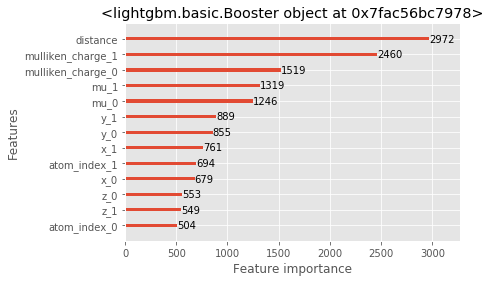

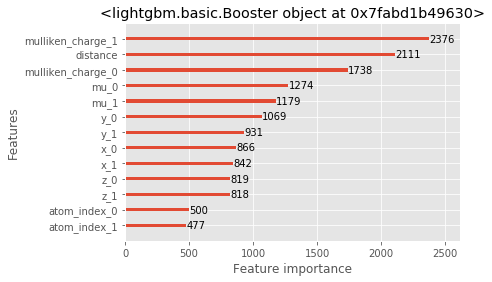

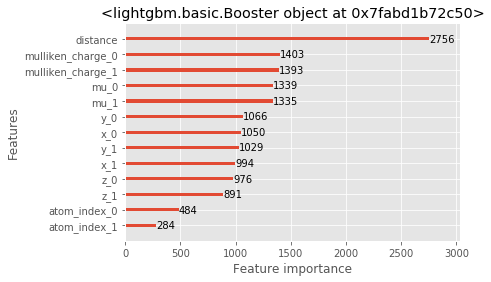

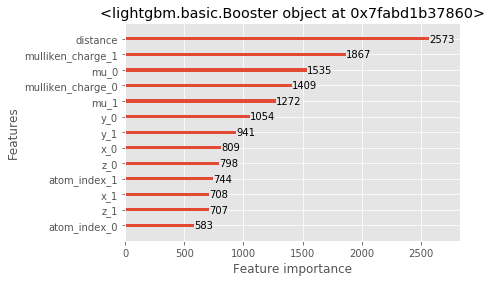

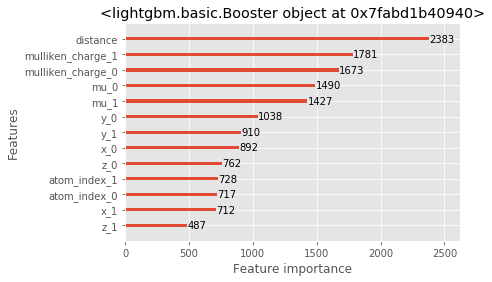

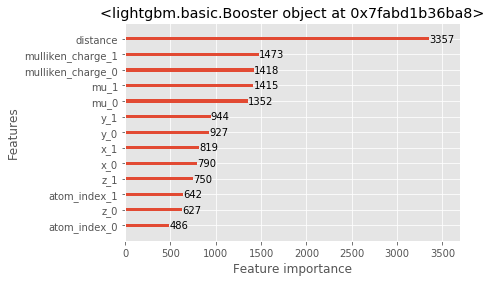

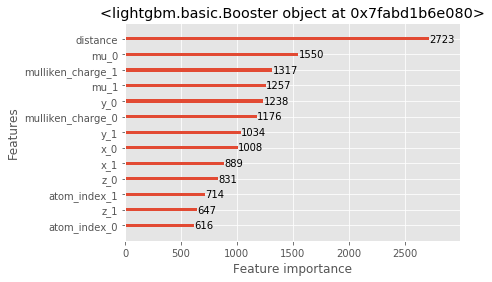

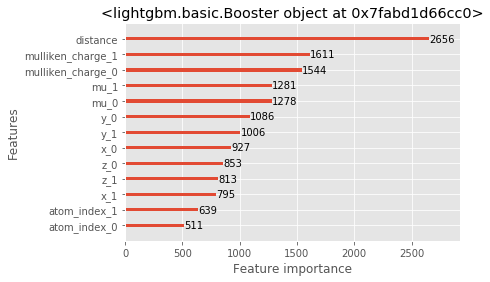

In [306]:
models = [model_lgb_1JHC, model_lgb_1JHN, model_lgb_2JHH, model_lgb_2JHN,
          model_lgb_2JHC, model_lgb_3JHH, model_lgb_3JHC, model_lgb_3JHN]

plt.style.use('ggplot')

for model in models:
  lightgbm.plot_importance(model, title=model)

